# NRC-35: OTE Water Ice Measurements with NIRCam

This activity will use NIRCam longwave grism spectra to check for ice contamination associated with the telescope and instrument cooldown.

## Part 1: Simulations

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

# Program bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import webbpsf, poppy, S
from pynrc.simul import apt, ngNRC

pynrc.setup_logging('WARN', verbose=True)

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
import os

from astropy import units as u
from astropy.io import fits, ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord

In [4]:
webbpsf_data_path = webbpsf.utils.get_webbpsf_data_path()

# Pupil and segment information
pupil_file = os.path.join(webbpsf_data_path, "jwst_pupil_RevW_npix1024.fits.gz")
pupil_hdul = fits.open(pupil_file)

segmap_file = os.path.join(webbpsf_data_path, "JWpupil_segments_RevW_npix1024.fits.gz")
segmap_hdul = fits.open(segmap_file)

In [5]:
from pynrc.nrc_utils import segment_pupil_opd, make_grism_slope
from pynrc.nrc_utils import bias_dark_high_temp as bias_dark
darks_80K_dir = '/Users/jarron/NIRCam/Data/NRC_80K/'

## OTE Ice Observations

1. Post LOS-02 pointing and background check **(L+40; OTE = Initial Deployment)**
 1. 31: Pointing Pre-Check (HD 84406)
 1. 32: Bgrd Levels Sub256 Pre-Check (HD 84406)
 1. 33: Star Levels Sub256 Pre-Check (HD 84406)
 1. 34: Bgrd Levels Sub64 Pre-Check (HD 84406)
 1. 35: Dark and Bias Pre-Check
1. Analysis Time **(6 hours)**
1. Pre FSM heater off NIRCam with Beam Probing **(L+40; OTE = Initial Deployment)**
 1. 1: LW Grism Ice Monitor #1 Mod-A 256 subarray (HD 84406)
 1. 22: Module A GrismR -V2 1 column 2 pts (HD 84406)
 1. 23: Module A GrismC +V2 1 pt (HD 84406)
 1. 24: Module B GrismR 256 subarray (HD 84406)
 1. 25: Module B GrismR +V2 1 column 2 pts (HD 84406)
 1. 26: Module B GrismC -V2 1 pt (HD 84406)
1. Post-FSM heater off NIRCam Observations
 1. 2: LW Grism Ice Monitor #2 (HD 84406) **(L+43; OTE = Initial Deployment)**
 1. 3: LW Grism Ice Monitor #3 (HD 84406) **(L+47; OTE = Segment Image Array 1)**
 1. 4: LW Grism Ice Monitor #4 (HD 84406) **(L+50; OTE = Global Alignment 1)**
 1. 5: LW Grism Ice Monitor #5 (BD+86-189) **(L+54; OTE = Image Stacking 1)**
 1. 6: LW Grism Ice Monitor #6 (TYC-8558-1141-1) **(L+58; OTE = Coarse Phasing 1)**
 1. 7: LW Grism Ice Monitor #7 (GCRV-21765) **(L+67; OTE = Fine Phasing 1)**
 1. 8: LW Grism Ice Monitor #8 (GCRV-21765) **(L+77; OTE = MIMF)**
 1. 9: LW Grism Ice Monitor #9 (GCRV-21765) **(L+96; OTE = MIMF)**

In [6]:
opd_dir = '/Users/jarron/NIRCam/Data/OTE_OPDs/'
# opd_dir = '/data/NIRData/NIRCam/OTE_OPDs/'

# 10 total observations, split into 5 pairs
obs_dict = {}

# L+40 - Use a segment from Deployment_OPDs[7]
hdul = fits.open(opd_dir + 'Deployment_OPDs.fits')
# hdul = fits.open(opd_dir + 'MM_WAS-GLOBAL_ALIGNMENT_WO_TT_R2017112104.fits')
opd_single = segment_pupil_opd(hdul[7], 'A3')
# Post LOS-02 pointing and background check
obs_dict['031:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40.0'}
obs_dict['032:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40.1'}
obs_dict['033:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40.2'}
obs_dict['034:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40.3'}
#obs_dict['035:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40', 'time':'16:00:00'}
# Pre FSM heater off NIRCam with Beam Probing
obs_dict['001:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40.5', 'offset':(5,10.5)}
obs_dict['022:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40.6'}
obs_dict['023:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40.7'}
obs_dict['024:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40.8'}
obs_dict['025:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40.9'}
obs_dict['026:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+41.0'}
# L+43 - Initial Deployment
obs_dict['002:001']  = {'opd': opd_single, 'jsig': 0.1, 'temp':80, 'day':'L+43'}

# L+47 - Segment Image Array 1
hdul = fits.open(opd_dir + 'MM_WAS-GLOBAL_ALIGNMENT_small_WITH_TT_R2017102404.fits')
obs_dict['003:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.1, 'temp':60, 'day':'L+47.4'}

# L+50 - Global Alignment 1
hdul = fits.open(opd_dir + 'MM_WAS-GLOBAL_ALIGNMENT_small_WITH_TT_N2017112103.fits')
obs_dict['004:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':50, 'day':'L+50.4'}

# L+54 - Image Stacking 1
hdul = fits.open(opd_dir + 'MM_COARSE_MIMF_N2017102403.fits')
obs_dict['005:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':45, 'day':'L+53.6'}

# L+58 - Coarse Phasing 1 (stacked)
hdul = fits.open(opd_dir + 'MM_COARSE_MIMF_R201710240A.fits')
obs_dict['006:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':42, 'day':'L+58.2'}

# L+67 - Fine Phasing 1 (stacked)
hdul = fits.open(opd_dir + 'MM_WAS-GLOBAL_ALIGNMENT_WO_TT_R2017112104.fits')
obs_dict['007:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':40, 'day':'L+66.8'}

# L+77/96 - MIMF
hdul = fits.open(opd_dir + 'MM_FINE_PHASING_R2017120405.fits')
obs_dict['008:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':40, 'day':'L+77.0'}
obs_dict['009:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':39, 'day':'L+96.4'}

In [7]:
# Define APT files
apt_dir = '../../APT_output/'
def init_visits(obs_dict, rand_seed_init=None):
    """Initialize visit and initial obs_params config"""
    
    keys = obs_dict.keys()

    # APT output files
    xml_file      = os.path.join(apt_dir, 'pid1409.xml')
    pointing_file = os.path.join(apt_dir, 'pid1409.pointing')
    json_file     = os.path.join(apt_dir, 'pid1409.timing.json')
    sm_acct_file  = os.path.join(apt_dir, 'pid1409.smart_accounting')
    
    # Define Launch date and time
    tlaunch = Time('2021-12-22 12:20:00')  
    # Populate dates and times for all observations
    for vkey in keys:
        d = obs_dict[vkey]
        lplus_days = float(d['day'][2:])
        tobs = tlaunch + lplus_days
        date_obs, time_obs = tobs.to_value('fits').split('T')
        d['date'] = date_obs
        d['time'] = time_obs
        
    # Read and interpret APT files
    # Observation of first date, not really necessary
    obs_date = obs_dict['031:001']['date']  
    apt_obj = apt.DMS_input(xml_file, pointing_file, json_file, sm_acct_file, 
                            obs_date=obs_date, rand_seed_init=rand_seed_init)
    visits = apt_obj.program_info
    
    # Create obs params for all LW observations only
    print('  Creating Observation Parameters...')
    for vkey in tqdm(keys, leave=False, desc='Visits'):
        visit = visits[vkey]
        
        # Update date and time before generating specific obs_params
        apt_obj.obs_date = obs_dict[vkey]['date']
        apt_obj.obs_time = obs_dict[vkey]['time']

        visit['exp_start_times'] = visit['exp_start_times'] - visit['exp_start_times'].min() + 1800

        # Select only a single exposure within visit
        index = 0 #if 'SUBGRISM256' in visit['subarray_name'] else 0
        oid = visit['obs_id_info'][index]
        mod = visit['ModuleAPT'][index]

        # Select only LW detector
        detid = 485 if mod=='A' else 490
        exp_id = oid['exposure_number']
        grp_id = oid['visit_group']
        seq_id = oid['sequence_id']
        act_id = oid['activity_id']

        obs_params = apt_obj.gen_obs_params(vkey, exp_id, detid, grp_id=grp_id, 
                                            seq_id=seq_id, act_id=act_id)
        
        # Store in obs_dict
        obs_dict[vkey]['obs_params'] = obs_params
        obs_dict[vkey]['visit'] = visit
        

In [8]:
def add_inst(obs_dict, key=None, ice_scale=None, nvr_scale=None, ote_scale=0, nc_scale=0, spec_ang=0):
    """Add NIRCam instrument class
    
    ice_scale : float
        Add in additional OTE H2O absorption. This is a scale factor
        relative to 0.0131 um thickness. Also includes about 0.0150 um of
        photolyzed Carbon.
    nvr_scale : float
        Modify NIRCam non-volatile residue. This is a scale factor relative 
        to 0.280 um thickness already built into filter throughput curves. 
        If set to None, then assumes a scale factor of 1.0. 
        Setting ``nvr_scale=0`` will remove these contributions.
    ote_scale : float
        Scale factor of OTE contaminants relative to End of Life model. 
        This is the same as setting ``ice_scale``. 
        Will override ``ice_scale`` value.
    nc_scale : float
        Scale factor for NIRCam contaminants relative to End of Life model.
        This model assumes 0.189 um of NVR and 0.050 um of water ice on
        the NIRCam optical elements. Setting this keyword will remove all
        NVR contributions built into the NIRCam filter curves.
        Overrides ``nvr_scale`` value.
    
    """
    
    
    print('  Generating Instrument Classes...')
    keys = obs_dict.keys() if key is None else np.asarray([key]).flatten()
    iter_keys = tqdm(keys, leave=False, desc='Visits') if len(keys)>1 else keys
    for vkey in iter_keys:
        d = obs_dict[vkey]
        
        # Visit info and obs
        visit = d['visit']
        obs_params = d['obs_params']
        
        filt       = obs_params['filter']
        pupil_mask = obs_params['pupil']
        image_mask = None if obs_params['coron_mask']=='NONE' else obs_params['coron_mask']
        apname     = obs_params['siaf_ap'].AperName

        input_pupil_hdul, input_opd_hdul = d['opd']
        jsig = d['jsig']
        d['ice_scale'] = ice_scale
        d['nvr_scale'] = nvr_scale
        d['ote_scale'] = ote_scale
        d['nc_scale'] = nc_scale
        nrc = pynrc.NIRCam(filter=filt, pupil_mask=pupil_mask, image_mask=image_mask,
                           fov_pix=257, oversample=2, autogen_coeffs=True,
                           ice_scale=d['ice_scale'], nvr_scale=d['nvr_scale'],
                           ote_scale=d['ote_scale'], nc_scale=d['nc_scale'],
                           pupil=input_pupil_hdul, pupilopd=input_opd_hdul,
                           save=False, force=True, quick=True)

        # Update detector information
        det = obs_params['det_obj']
        kw = {**det.to_dict(), **det.multiaccum.to_dict()}
        nrc.update_detectors(**kw)
        d['nrc'] = nrc


In [9]:
def add_slope_images(obs_dict, key=None, spec_ang=0, add_offset=None, **kwargs):
    """Generate slope image(s)"""
        
    print('  Creating ideal slopes, FSM background, SCA darks, biases...')
    keys = obs_dict.keys() if key is None else np.asarray([key]).flatten()
    iter_keys = tqdm(keys, leave=False, desc='Visits') if len(keys)>1 else keys
    for vkey in iter_keys:
        d = obs_dict[vkey]

        nrc = d['nrc']
        # Visit info and obs
        visit = d['visit']
        obs_params = d['obs_params']

        T = d['temp']
        
        # Change collecting area to modify flux 
        input_pupil_hdul, input_opd_hdul = d['opd']
        coll_area_seg = 25.78e4 * input_pupil_hdul[0].data.sum() / pupil_hdul[0].data.sum()
        S.refs.setref(area=coll_area_seg)

        # Create source table
        ra  = obs_params['ra']
        dec = obs_params['dec']
        coords = SkyCoord(ra, dec, unit=(u.deg, u.deg), 
                          frame='icrs', equinox='J2000', obstime='J2000')
        ra, dec = (coords.ra.deg, coords.dec.deg)
        # src_tbl = ngNRC.make_gaia_source_table(coords, remove_cen_star=False)
        src_tbl = ngNRC.make_simbad_source_table(coords, remove_cen_star=False)
        d['src_tbl'] = src_tbl
        
        # Create pointing information
        tel_point = apt.gen_jwst_pointing(visit, obs_params)
        expnum  = int(obs_params['obs_id_info']['exposure_number'])
        print(f"  Exposure: {expnum}")

        # Get offset
        if add_offset is None:
            add_offset = d.get('offset')
        if add_offset is None:
            add_offset = np.array([0,0])
            
        ind = np.where(tel_point.exp_nums == expnum)[0][0]
        idl_off = tel_point.position_offsets_act[ind]
        obs_params['xoffset_act'] = idl_off[0] + add_offset[0]
        obs_params['yoffset_act'] = idl_off[1] + add_offset[1]

        # Get ideal slope
        res = make_grism_slope(nrc, src_tbl, tel_point, expnum,
                               add_offset=add_offset, spec_ang=spec_ang, 
                               **kwargs)

        wspec_all, im_slope_ideal = res
            
        # Add to dict
        d['wave'] = wspec_all
        d['im_slope_ideal'] = im_slope_ideal
        
        # Create background slope image
        im_bg_zodi = nrc.bg_zodi_image()
        # Scale background counts by T**4
        bg_cnts = 2000 * (T**4-39.0**4)/(80.0**4-39.0**4) 
        im_bg_pom = bg_cnts * im_bg_zodi / im_bg_zodi.max()
        d['bg_slope'] = im_bg_pom + im_bg_zodi
        
        # Add dark slope and bias images
        bias, dark = bias_dark(darks_80K_dir, T=T)
        
        # Grab subarray region of bias and dark frames
        x1 = nrc.det_info['x0']
        x2 = x1 + nrc.det_info['xpix']
        y1 = nrc.det_info['y0']
        y2 = y1 + nrc.det_info['ypix']

        # These are in 'det' coords, while slopes are in 'sci' coords
        d['im_bias'] = bias[y1:y2, x1:x2]
        d['im_dark'] = dark[y1:y2, x1:x2]        
        

In [10]:
def generate_level1b(obs_dict, key=None, save_dir=None, save_slope=True, **kwargs):

    from pynrc.simul.dms import level1b_data_model, save_level1b_fits
    from pynrc.simul.ngNRC import save_slope_image
    from stdatamodels import fits_support
    
    kwargs['out_ADU'] = True
            
    keys = obs_dict.keys() if key is None else np.asarray([key]).flatten()
    iter_keys = tqdm(keys, leave=False, desc='Visits') if len(keys)>1 else keys
    for vkey in iter_keys:
        d = obs_dict[vkey]
        obs_params = d['obs_params']
        nrc        = d['nrc']
                
        # 'sci' coords
        im_slope = d['im_slope_ideal'] + d['bg_slope']
        
        if save_slope:
            save_slope_image(im_slope, obs_params, save_dir=save_dir, **kwargs)
        
        # Get sci data ramps
        rand_seed_noise_j = obs_params['rand_seed_noise']
        res = nrc.simulate_ramps(im_slope=im_slope, rand_seed=rand_seed_noise_j,
                                 super_bias=d['im_bias'], super_dark=d['im_dark'], **kwargs)
        sci_data, zero_data = res
        
        # Generate Level-1b FITS
        outModel = level1b_data_model(obs_params, sci_data=sci_data, zero_data=zero_data)

        # Grab ice and nvr information
        kwargs['ice_scale'] = nrc._ice_scale
        kwargs['nvr_scale'] = nrc._nvr_scale
        kwargs['nc_scale']  = nrc._nc_scale
        kwargs['ote_scale'] = nrc._ote_scale
        save_level1b_fits(outModel, obs_params, save_dir=save_dir, **kwargs)        


In [11]:
def run_all_exps(obs_dict, key=None, save_dir=None, rand_seed_init=None, save_slope=True, **kwargs):
    """Run all exposures within visit
    
    Assumes visits and NIRCam objects have been initialized.
    """
    
    # APT output files
    xml_file      = os.path.join(apt_dir, 'pid1409.xml')
    pointing_file = os.path.join(apt_dir, 'pid1409.pointing')
    json_file     = os.path.join(apt_dir, 'pid1409.timing.json')
    sm_acct_file  = os.path.join(apt_dir, 'pid1409.smart_accounting')
    
    kwargs['json_file']     = os.path.basename(json_file)
    kwargs['sm_acct_file']  = os.path.basename(sm_acct_file)
    kwargs['pointing_file'] = os.path.basename(pointing_file)
    kwargs['xml_file']      = os.path.basename(xml_file)
    
    # Read and interpret APT files
    # Observation of first date, not really necessary
    apt_obj = apt.DMS_input(xml_file, pointing_file, json_file, sm_acct_file, 
                            rand_seed_init=rand_seed_init)
    
    keys = obs_dict.keys() if key is None else np.asarray([key]).flatten()
    iter_keys = tqdm(keys, leave=False, desc='Visits') if len(keys)>1 else keys
    for vkey in iter_keys:
        d = obs_dict[vkey]
        visit = d['visit']

        nexp = len(visit['obs_id_info'])
        # Select only a given exposure within visit
        for index in range(nexp):
            
            oid = visit['obs_id_info'][index]
            mod = visit['ModuleAPT'][index]

            # Select only LW detector
            detid = 485 if mod=='A' else 490
            exp_id = oid['exposure_number']
            grp_id = oid['visit_group']
            seq_id = oid['sequence_id']
            act_id = oid['activity_id']
            act_int = np.int(act_id, 36) # Convert base 36 to integer number

            # Generate new obs_params and store in obs_dict
            obs_params = apt_obj.gen_obs_params(vkey, exp_id, detid, grp_id=grp_id, 
                                                seq_id=seq_id, act_id=act_id)
            obs_dict[vkey]['obs_params'] = obs_params
        
            # Generate ideal slope image and wavelength solution
            #   obs_dict[vkey]['wave'] = wspec_all  # wavelengths for all
            #   obs_dict[vkey]['im_slope_ideal'] = im_slope_ideal
            add_slope_images(obs_dict, key=key, add_offset=(5,10.5), spec_ang=0)
            
            # Save Level1b FITS file
            generate_level1b(obs_dict, key=key, save_dir=save_dir, save_slope=save_slope, **kwargs)

In [12]:
# Store obs_params and visit info in in obs_dict:
#   obs_dict[vkey]['obs_params'] = obs_params
#   obs_dict[vkey]['visit'] = visit
init_visits(obs_dict, rand_seed_init=1234)

  Creating Observation Parameters...


Visits:   0%|          | 0/18 [00:00<?, ?it/s]

In [13]:
# Create NIRCam instrument class:
#   obs_dict[vkey]['nrc'] = nrc
kw_scales = {'ote_scale': 0.5, 'nc_scale': 0.5, 'ice_scale': None, 'nvr_scale': None}
add_inst(obs_dict, key='001:001', **kw_scales)

  Generating Instrument Classes...


Monochromatic PSFs:   0%|          | 0/21 [00:00<?, ?it/s]

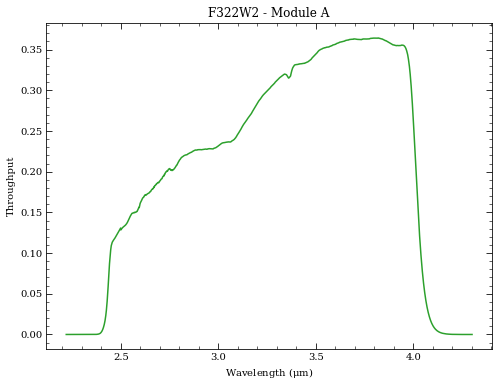

In [14]:
vkey = '001:001'
nrc = obs_dict[vkey]['nrc']
nrc.plot_bandpass();

## Check slope image extraction

In [15]:
# Create slope and check extraction
vkey = '001:001'
add_slope_images(obs_dict, key=vkey, add_offset=(5,10.5), spec_ang=0)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1


In [16]:
# Verify slope image looks right
d = obs_dict[vkey]
im_slope = d['im_slope_ideal']
wave = d['wave']
nrc = d['nrc']
src_tbl = d['src_tbl']

In [17]:
src_tbl

index,ra,dec,K-Band,dist,SpType,F070W,F090W,F115W,F140M,F150W,F150W2,F162M,F164N,F182M,F187N,F200W,F210M,F212N,F250M,F277W,F300M,F322W2,F323N,F335M,F356W,F360M,F405N,F410M,F430M,F444W,F460M,F466N,F470N,F480M
,deg,deg,mag,arcsec,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float32,float32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,146.87727491,63.24780476,4.698,2.7190957,G5V,5.779,5.478,5.217,4.917,4.842,4.936,4.743,4.711,4.719,4.703,4.712,4.701,4.703,4.7,4.688,4.682,4.686,4.686,4.684,4.684,4.683,4.663,4.683,4.691,4.701,4.724,4.695,4.72,4.717
2,146.81478027,63.28792868,13.924,177.17578,G2V,14.82,14.569,14.352,14.095,14.035,14.121,13.956,13.931,13.942,13.93,13.936,13.926,13.928,13.92,13.914,13.913,13.914,13.917,13.915,13.915,13.915,13.898,13.914,13.917,13.922,13.931,13.905,13.928,13.927
3,146.84271400,63.31572700,13.676,252.55495,G2V,14.572,14.321,14.104,13.847,13.787,13.873,13.708,13.683,13.694,13.682,13.688,13.678,13.68,13.672,13.666,13.665,13.666,13.669,13.667,13.667,13.667,13.65,13.666,13.669,13.674,13.683,13.657,13.68,13.679
4,146.95336467,63.17027856,13.736,303.92145,G2V,14.632,14.381,14.164,13.907,13.847,13.933,13.768,13.743,13.754,13.742,13.748,13.738,13.74,13.732,13.726,13.725,13.726,13.729,13.727,13.727,13.727,13.71,13.726,13.729,13.734,13.743,13.717,13.74,13.739


In [18]:
# Extract spectrum
# No noise, so just sum full spectrum
spec_extract = im_slope.sum(axis=0)[::-1]
wspec = wave[0].mean(axis=0)[::-1]

# pysynphot observation of spectrum plus bandpass
bp = nrc.bandpass
sp = pynrc.stellar_spectrum(src_tbl[0]['SpType'], src_tbl[0][bp.name], 'vegamag', bp)
# Rebin spectrum
sp = nrc_utils.bin_spectrum(sp, np.sort(wspec), waveunits='um')

obs = S.Observation(sp, bp, binset=sp.wave, force='taper')
obs.convert('counts')


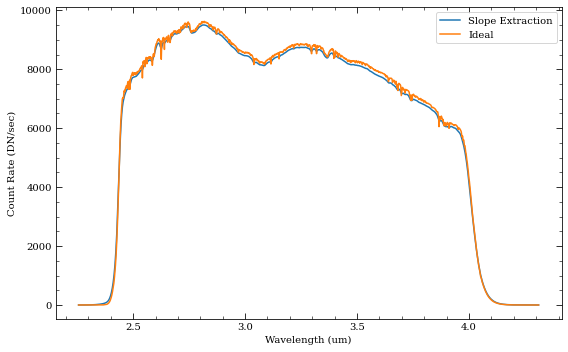

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(wspec, spec_extract, label='Slope Extraction')
ax.plot(obs.binwave/1e4, obs.binflux, label='Ideal')

ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Count Rate (DN/sec)')

ax.legend()

fig.tight_layout()

## Run Simulations

In [20]:
# Create and save DMS FITS files
save_dir = '/Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/'
params_noise = {
    'include_poisson'   : True,     # Photon Noise
    'include_dark'      : True,     # Dark current
    'include_bias'      : True,     # Bias image offset
    'include_ktc'       : True,     # kTC Noise
    'include_rn'        : True,     # Read Noise
    'include_cpink'     : True,     # Correlated 1/f noise between channel
    'include_upink'     : True,     # Channel-dependent 1/f noise
    'include_acn'       : True,     # Alternating column noise
    'apply_ipc'         : True,     # Interpixel capacitance
    'apply_ppc'         : True,     # Post-pixel coupling
    'amp_crosstalk'     : True,     # Amplifier crosstalk
    'include_refoffsets': True,     # Reference offsets
    'include_refinst'   : True,     # Reference pixel instabilities
    'include_colnoise'  : True,     # Transient detector column noise
    'add_crs'           : True,     # Include cosmic ray
    'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
    'cr_scale'          : 1,        # Cosmic ray probabilities scaling
    'apply_nonlinearity': True,     # Apply non-linearity
    'random_nonlin'     : True,     # Add randomness to non-linearity
    'apply_flats'       : True,     # pixel-to-pixel QE variations and field-dep illum
}

run_all_exps(obs_dict, key='001:001', rand_seed_init=1234, 
             save_dir=save_dir, save_slope=True, **params_noise)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1
  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/slope_jw01409001001_02101_00001_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/jw01409001001_02101_00001_nrca5_uncal.fits
  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 2
  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/slope_jw01409001001_02101_00002_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/jw01409001001_02101_00002_nrca5_uncal.fits


# Extra Backup Cells

In [41]:
d = obs_dict['001:001']
obs_params = d['obs_params']
visit = d['visit']

In [42]:
visit

{'obs_num': 1,
 'visit_num': 1,
 'visit_start': 23416,
 'slew_duration': 1800,
 'visit_duration': 1167,
 'exp_start_times': array([1800, 2310]),
 'orient_info': {'OrientMin': 190.0, 'OrientMax': 210.0},
 'APTTemplate': 'NircamEngineeringImaging',
 'PrimaryDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'PrimaryDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherSize': array(['NONE', 'NONE'], dtype='<U4'),
 'SubpixelPositions': array(['1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD'], dtype='<U8'),
 'SmallGridDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherPatternType': array(['NONE', 'NONE'], dtype='<U4'),
 'ImageDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'number_of_dithers': array(['1', '1'], dtype='<U1'),
 'rand_seed_init': 1234,
 'rand_seed_dith': 3853010524,
 'rand_seed_noise': 3709225223,
 'TargetID': array(['HD-84406', 'HD-84406'], dtype='<U15'),
 'TargetRA': array(['09:47:30.2970', '09:47:30.2970'], dtype='<U13'),
 'TargetDec

In [43]:
obs_params

{'pi_name': 'Erin Smith',
 'title': 'CAR_NIRCAM-0035: NIRCAM Ice Measurement',
 'category': 'COM',
 'sub_category': 'NIRCAM',
 'science_category': 'Stellar Physics',
 'target_name': 'HD-84406',
 'catalog_name': 'UNKNOWN',
 'ra': 146.8762375,
 'dec': 63.24721111111111,
 'pa_v3': 196.9098730681069,
 'roll_offset': 0,
 'solar_elong': 133.21178164562465,
 'pitch_ang': 43.211781645624654,
 'siaf_ap': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_obs': 146.87577594106958,
 'dec_obs': 63.246586256447664,
 'siaf_ap_ref': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_ref': 146.87577594106958,
 'dec_ref': 63.246586256447664,
 'date-obs': '2022-02-01',
 'time-obs': '00:20:00.000',
 'obs_id_info': {'program_number': '01409',
  'observation_number': '001',
  'visit_number': '001',
  'visit_group': '02',
  'sequence_id': '1',
  'activity_id': '01',
  'exposure_number': '00001',
  'visit_id': '01409001001',
  'obs_id': 'V01409001001P0000000002101'},
 'obs_label': 'LW